In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving parkinsons.csv to parkinsons.csv


In [ ]:
import pandas as pd
df_parkinsons = pd.read_csv('parkinsons.csv')
print(df_parkinsons.head())

   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0      119.992       157.302        74.997         0.00784           0.00007   
1      122.400       148.650       113.819         0.00968           0.00008   
2      116.682       131.111       111.555         0.01050           0.00009   
3      116.676       137.871       111.366         0.00997           0.00009   
4      116.014       141.781       110.655         0.01284           0.00011   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0   0.00370   0.00554     0.01109       0.04374             0.426  ...   
1   0.00465   0.00696     0.01394       0.06134             0.626  ...   
2   0.00544   0.00781     0.01633       0.05233             0.482  ...   
3   0.00502   0.00698     0.01505       0.05492             0.517  ...   
4   0.00655   0.00908     0.01966       0.06425             0.584  ...   

   Shimmer:DDA      NHR     HNR      RPDE       DFA   spread1   spread2  \

In [ ]:
f = df_parkinsons.drop('Diagnosis', axis=1)

t = df_parkinsons['Diagnosis']

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

class DecisionTree:
    def __init__(self, f_i=None, delta=None, l_l=None, l_r=None, *, leaf_val=None, min_l=2, max_d=100, num_f=None, random_state=None):
        self.f_i = f_i
        self.delta = delta
        self.l_l = l_l
        self.l_r = l_r
        self.leaf_val = leaf_val
        self.min_l = min_l
        self.max_d = max_d
        self.num_f = num_f
        self.random_state = random_state
        if self.random_state is not None:
            np.random.seed(self.random_state)

    def leaf(self):
        return self.leaf_val is not None

    def train1(self, X1, y1):
        self.num_f = X1.shape[1] if self.num_f is None else min(X1.shape[1], self.num_f)
        self.root = self.subtree(X1, y1)

    def subtree(self, X1, y1, d=0):
        if self.stop_split(X1, y1, d):
            return DecisionTree(leaf_val=self.mfl(y1))
        top_f, top_delta = self.find_best_split(X1, y1)
        if top_f is None or top_delta is None:
            return DecisionTree(leaf_val=self.mfl(y1))
        return self.split_recurse(X1, y1, d)


    def stop_split(self, X1, y1, d):
        return d >= self.max_d or len(np.unique(y1)) == 1 or X1.shape[0] < self.min_l

    def split_recurse(self, X1, y1, d):
        top_f, top_delta = self.find_best_split(X1, y1)

        if top_f is None or top_delta is None:
            return DecisionTree(leaf_val=self.mfl(y1))

        l_i, r_i = self.data(X1[:, top_f], top_delta)
        return DecisionTree(
            f_i=top_f,
            delta=top_delta,
            l_l=self.subtree(X1[l_i, :], y1[l_i], d + 1),
            l_r=self.subtree(X1[r_i, :], y1[r_i], d + 1)
        )

    def find_best_split(self, X1, y1):
        top_gain, top_f, top_delta = -1, None, None
        m = int(np.sqrt(X1.shape[1]))
        for f in np.random.choice(X1.shape[1], m, replace=False):
            unique_vals = np.unique(X1[:, f])
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2  # Midpoints as thresholds
            for delta in thresholds:
                gain = self.ig(y1, X1[:, f], delta)
                if gain > top_gain:
                    top_f, top_delta, top_gain = f, delta, gain
        return top_f, top_delta

    def ig(self, y1, f_val, delta):
        ancestor_e = self.e(y1)
        l_i, r_i = self.data(f_val, delta)
        if not l_i.size or not r_i.size:
            return 0
        return ancestor_e - self.weighted_e(y1, l_i, r_i)

    def weighted_e(self, y1, l_i, r_i):
        total = len(y1)
        return (len(l_i) / total) * self.e(y1[l_i]) + (len(r_i) / total) * self.e(y1[r_i])

    def e(self, y1):
        if not y1.size:
            return 0
        p = np.bincount(y1.astype(int)) / len(y1)
        return -np.sum(p[p > 0] * np.log2(p[p > 0]))

    def data(self, f_val, delta):
        return np.where(f_val <= delta)[0], np.where(f_val > delta)[0]

    def mfl(self, y1):
        return Counter(y1).most_common(1)[0][0]

    def pediting(self, X1):
        return np.array([self.tt(sample, self.root) for sample in X1])

    def tt(self, n, r):
        if r.leaf():
            return r.leaf_val
        return self.tt(n, r.l_l if n[r.f_i] <= r.delta else r.l_r)

In [ ]:
class RandomForest:
    def __init__(self, n_trees=10, min_l=2, max_d=100, num_f=None, random_state=42):
        self.n_trees = n_trees
        self.min_l = min_l
        self.max_d = max_d
        self.num_f = num_f
        self.random_state = random_state
        self.t_arrayno = []

    def b_s(self, f, t):
        n_samples = f.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return f[indices], t[indices]

    def fitting(self, f, t):
        self.t_arrayno = []
        for _ in range(self.n_trees):
            f_sample, t_sample = self.b_s(f, t)
            decision_tree = DecisionTree(min_l=self.min_l, max_d=self.max_d, num_f=self.num_f, random_state=self.random_state)
            decision_tree.train1(f_sample, t_sample)
            self.t_arrayno.append(decision_tree)

    def pedting(self, f):
        prediction_made_by_tree = np.array([tree.pediting(f) for tree in self.t_arrayno])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=prediction_made_by_tree)


def mskf(f, t, k=5, seed=42):
    np.random.seed(seed)
    diff_cls, num_of_class = np.unique(t, return_counts=True)
    class_idxs = {label: np.where(t == label)[0] for label in diff_cls}

    for label in diff_cls:
        np.random.shuffle(class_idxs[label])

    f_f = [[] for _ in range(k)]
    for label in diff_cls:
        kfold_cls_len = np.array_split(class_idxs[label], k)
        for fold_idx, subset in enumerate(kfold_cls_len):
            f_f[fold_idx].extend(subset)

    return [np.array(fold) for fold in f_f]

f = f.to_numpy()
t = t.to_numpy()
def stratified_kf(f, t, n_trees_list, k=10):
    f_folds = mskf(f, t, k=k)
    rst = {ntree: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for ntree in n_trees_list}

    for i in range(k):
        test_idx = f_folds[i]
        train_idx = np.hstack([f_folds[j] for j in range(k) if j != i])
        f_train, f_test = f[train_idx], f[test_idx]
        t_train, t_test = t[train_idx], t[test_idx]

        for ntree in n_trees_list:
            rf = RandomForest(n_trees=ntree, min_l=2, max_d=10, num_f=None, random_state=42)
            rf.fitting(f_train, t_train)
            t_pred = rf.pedting(f_test)
            acc, prec, rec, f1 = compute_metrics(t_test, t_pred)

            rst[ntree]['accuracy'].append(acc)
            rst[ntree]['precision'].append(prec)
            rst[ntree]['recall'].append(rec)
            rst[ntree]['f1'].append(f1)

    return {nt: {metric: np.mean(rst[nt][metric]) for metric in rst[nt]} for nt in n_trees_list}


def compute_metrics(t_true, t_pred):
    labels = np.unique(t_true)
    precisions = []
    recalls = []
    f1_scores = []

    for label in labels:
        TP = np.sum((t_true == label) & (t_pred == label))
        FP = np.sum((t_true != label) & (t_pred == label))
        FN = np.sum((t_true == label) & (t_pred != label))

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    acc = np.sum(t_true == t_pred) / len(t_true)
    precision_macro = np.mean(precisions)
    recall_macro = np.mean(recalls)
    f1_macro = np.mean(f1_scores)

    return acc, precision_macro, recall_macro, f1_macro


def plotting(results, title="RF Metric"):
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        plt.plot(list(results.keys()), [results[ntree][metric] for ntree in results.keys()], marker='o', linestyle='-', label=metric)
        plt.xlabel("Number of Trees")
        plt.ylabel(metric.capitalize())
        plt.title(f"{title} - {metric.capitalize()}")
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
def print_results(results):
    print(f"{'Trees':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10}")
    for ntree, metrics in results.items():
        print(f"{ntree:<10} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} {metrics['f1']:<10.4f}")

Trees      Accuracy   Precision  Recall     F1        
1          0.7964     0.7387     0.7605     0.7410    
5          0.8253     0.7854     0.8067     0.7855    
10         0.8253     0.7860     0.8000     0.7829    
15         0.8203     0.7800     0.7967     0.7773    
20         0.8253     0.7854     0.8067     0.7855    
25         0.8253     0.7854     0.8067     0.7855    
30         0.8203     0.7800     0.7967     0.7773    
35         0.8203     0.7800     0.7967     0.7773    
40         0.8253     0.7854     0.8067     0.7855    
45         0.8253     0.7854     0.8067     0.7855    
50         0.8203     0.7800     0.7967     0.7773    


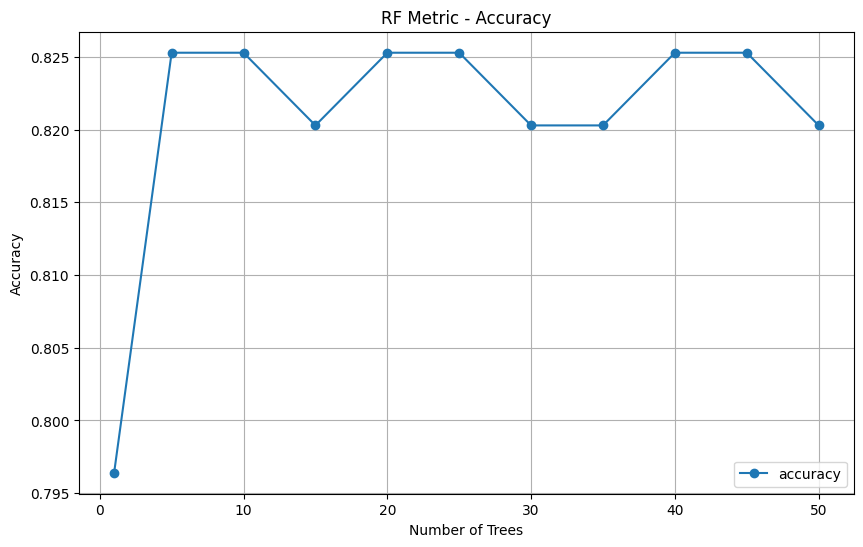

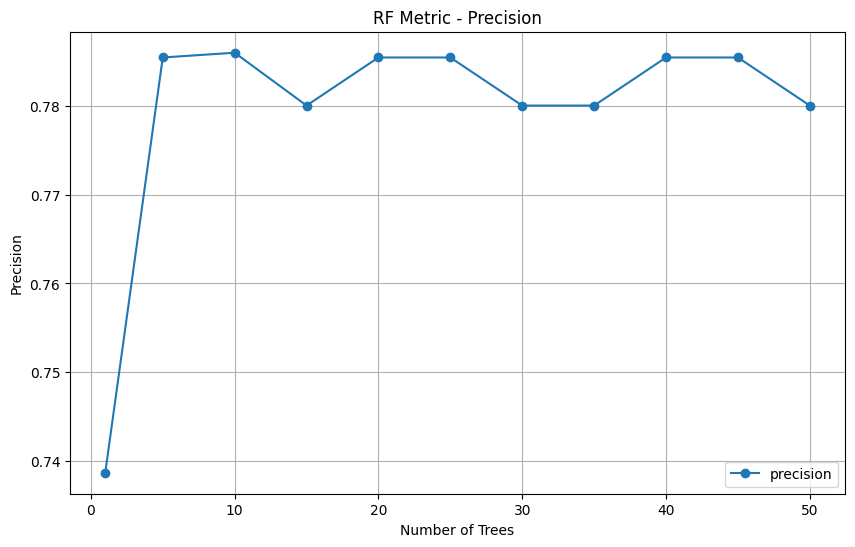

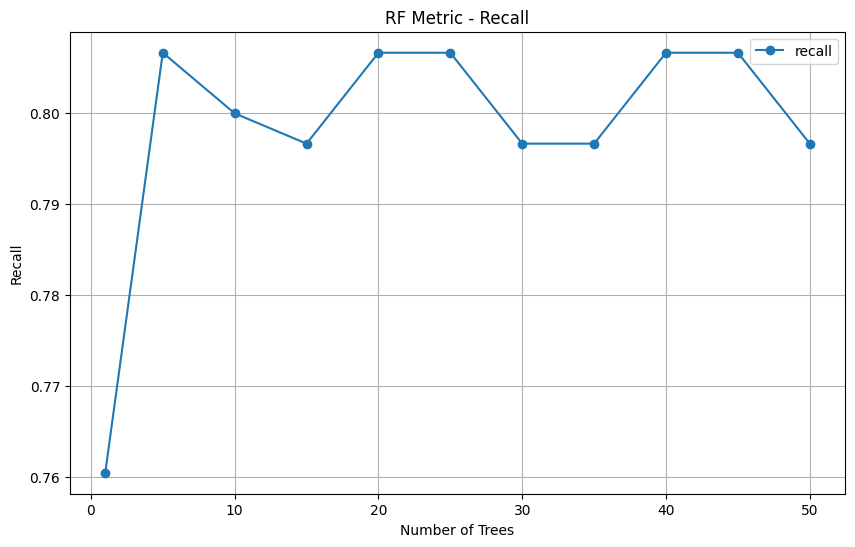

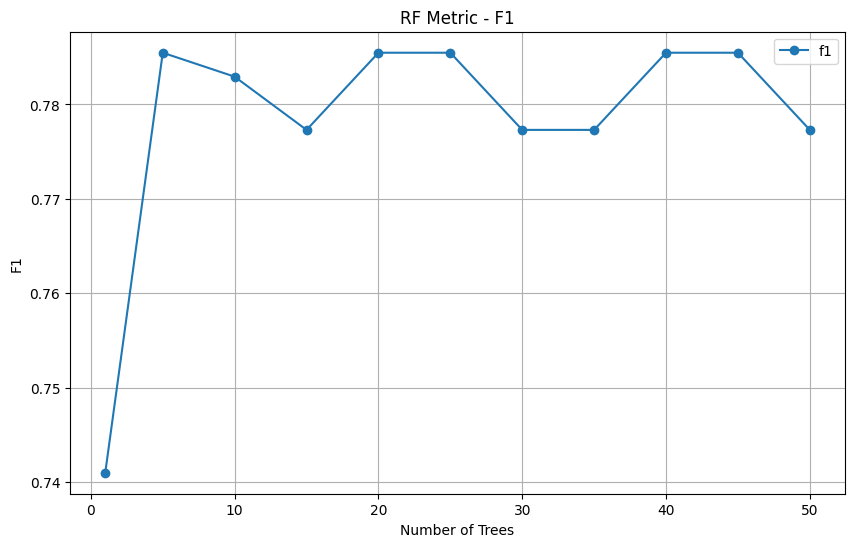

In [ ]:
results = stratified_kf(f, t, n_trees_list=[1, 5, 10, 15, 20, 25,30,35,40,45,50], k=10)
print_results(results)
plotting(results)